In [91]:
%pylab inline
import sys
sys.path.append('../build_gcc/')
import versor as vsr
from liblds_calibration import (LaserDistanceSensorCalibrator, transform_tangent_vector)
from game import solver_options

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Laser Distance Sensor Calibration

$$ R = \frac{1 + \mathrm{b}\mathrm{a}}{\sqrt{2(1 + \mathrm{b} \rfloor \mathrm{a})}} $$

In [92]:
rotor_from_vectors = lambda a, b: (b * a + 1) / np.sqrt(2*(1+(b <= a)[0]))

## Create measurement poses

In [93]:
# laser direction in end-effector
l0 = vsr.Vec(1,0,0).spin( vsr.Rot.from_bivector(vsr.Biv(1,0,0) * pi/ 3))
p0 = vsr.Vec(0.1,0.2,0.3)
R0 = rotor_from_vectors(vsr.Vec(1,0,0), l0)
T0 = vsr.Trs.from_vector(p0)
M_laser_in_ee = T0 * R0
print(M_laser_in_ee)

0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  


In [94]:
# Laser sensor
lower = 0.065
upper = 0.095
# lower = 0.01
# upper = lower + 0.2
generate_measurement_distance = lambda : (upper - lower) * np.random.rand() + lower

In [165]:
def create_point_on_sphere():
    r = generate_measurement_distance()
    theta = np.random.rand() * np.pi / 2.0
    phi = np.random.rand() * np.pi * 2.0 
    return vsr.Vec(r*np.sin(theta)*np.cos(phi),
                   r*np.sin(theta)*np.sin(phi),
                   r*np.cos(theta)), r

Create point on upper hemisphere on measurement sphere:

$$ 
x = r \sin (\theta) \cos(\varphi),\
y = r \sin (\theta) \cos(\varphi),\ 
z = r \cos(\varphi) 
$$

In [166]:
def generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane):
    # Model laser as tangent vector in the e_1-direction at the origin
    lds_dir = vsr.Vec(1,0,0)
    lds_tnv = vsr.no ^ lds_dir
    # Model the measurement plane as plane through the orgin with
    # normal vector \hat{n} = e_3
    dlp = dlp = vsr.Dlp(0,0,1,0)
    # Create point on upper hemisphere of measurement sphere with 
    # radius equals the measurement distance
    p, radius = create_point_on_sphere()
    # Compute motor that aligns lds_dir with measurement vector from 
    # from point on circle to the origin
    R = rotor_from_vectors(lds_dir, -p.unit())
    T = vsr.Trs.from_vector(p)
    M_on_sphere = T * R * vsr.Rot.from_bivector(vsr.Vec(1,0,0).duale() * 
                                                np.random.rand() * 2 * pi)
    # Transform the everything the measurement plane
    x_in_plane = np.random.rand()
    y_in_plane = np.random.rand()
    T_in_plane = vsr.Trs.from_vector(vsr.Vec(x_in_plane, y_in_plane, 0.0)) * vsr.Rot(1.0,0.0,0.0,0.0)
    # Transform the plane
    dlp_meas = dlp.spin(M_plane)
    M2 = M_plane * T_in_plane * M_on_sphere * M_laser_in_ee.rev()   
    return M2, dlp_meas, radius

In [167]:
# M, dlp, r = generate_measurement_pose_and_plane_and_distance(M_laser_in_ee)
# t2 = transform_tangent_vector(M * M_laser_in_ee,  (vsr.no ^ vsr.Vec(1,0,0)))
# s = (dlp <= t2) / (vsr.ni <= (dlp <= t2))[0]
# np.allclose(r, np.sqrt((s <= s)[0]))

In [168]:
lin = (p0.null() ^ (l0 ^ vsr.ni))
print (p0.null() ^ vsr.ni)

0.1  0.2  0.3  1  


In [169]:
M_plane = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,0,1), 0, vsr.Vec(1,1,0))
measurements1 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane) for i in range(10)]
M_plane2 = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,1,0), np.pi/3, vsr.Vec(1,1,0.0))
measurements2 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane2) for i in range(10)]
M_plane3 = vsr.Mot.from_dir_ang_trs(vsr.Vec(1,0,0), np.pi/2, vsr.Vec(1,1,0.0))
measurements3 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane3) for i in range(10)]
measurements = measurements1 + measurements2 + measurements3
measurements_copy = np.array(measurements).copy()

In [170]:
print M_plane

1  -0  0  -0  -0.5  -0.5  0  0  


In [171]:
options = solver_options()
options['function_tolerance'] = 1e-12
options['parameter_tolerance'] = 1e-12
options['max_num_iterations'] = 100
options['num_linear_solver_threads'] = 100
options['num_threads'] = 100
# options['trust_region_strategy_type'] = 'DOGLEG'
# options['linear_solver_type'] = 'SPARSE_NORMAL_CHOLESKY'

0.952942  -0.303153  0  0  -0.0905233  -0.0866345  -0.152471  0.0485044  
0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  
0.865762  -0.499848  0.0123306  -0.0213573  -0.0914233  -0.0647874  -0.128345  0.0772781  
Ceres Solver Report: Iterations: 15, Initial cost: 1.539003e+01, Final cost: 3.785124e-21, Termination: CONVERGENCE


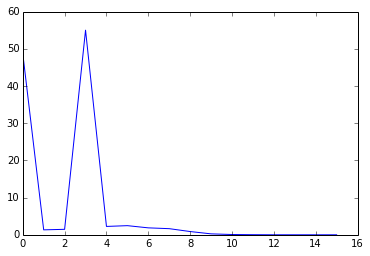

In [237]:
# M_plane = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,0,1), 0, vsr.Vec(1,1,0))
# measurements1 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane) for i in range(10)]
# M_plane2 = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,1,0), np.pi/3, vsr.Vec(1,1,0.0))
# measurements2 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane2) for i in range(10)]
# M_plane3 = vsr.Mot.from_dir_ang_trs(vsr.Vec(1,0,0), np.pi/2, vsr.Vec(1,1,0.0))
# measurements3 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane3) for i in range(10)]
# measurements = measurements1 + measurements2 + measurements3
# measurements_copy = np.array(measurements).copy()

# laser direction in end-effector
l = vsr.Vec(1,0,0).unit().spin(vsr.Rot.from_bivector(vsr.Biv(1,0,0).unit() * np.pi/5.1))
p = vsr.Vec(0.1 + 0.02, 0.2 + 0.02, 0.3 + 0.02)
R = rotor_from_vectors(vsr.Vec(1,0,0), l)
T = vsr.Trs.from_vector(p)
M_initial = T * R

print(M_initial)

print(M_laser_in_ee)

lds_calibrator = LaserDistanceSensorCalibrator(M_initial, options)

for measurement in measurements:
    lds_calibrator.add_tangent_vector_residual_block(*measurement)

# lds_calibrator.set_parameterization('POLAR_DECOMPOSITION')

lds_calibrator.set_parameterization('BIVECTOR_GENERATOR')

motor, summary = lds_calibrator.solve()

print(motor)
print(summary['brief_report'])

iterations = summary['iterations']
plot([it['gradient_max_norm'] for it in iterations])

In [158]:
print M_laser_in_ee

0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  


In [110]:
errors = []
for measurement in measurements:
    dlp = measurement[1]
    t = transform_tangent_vector(measurement[0] * motor,  (vsr.no ^ vsr.Vec(1,0,0)))
    s = (dlp <= t) / (vsr.ni <= (dlp <= t))[0]
    r_est = np.sqrt((s <= s)[0])
    errors.append(np.abs(r_est - measurement[2]))
print(np.sum(errors) / 1000)

0.000256403354801


In [111]:
print(vsr.Vec(0,0,0).null().spin(motor).to_array())
np.allclose(vsr.Vec(0,0,0).null().spin(motor).to_array(), 
            vsr.Vec(0,0,0).null().spin(M_laser_in_ee).to_array())

[ 0.06353575  0.24247041  0.29578398  1.          0.07515843]


False

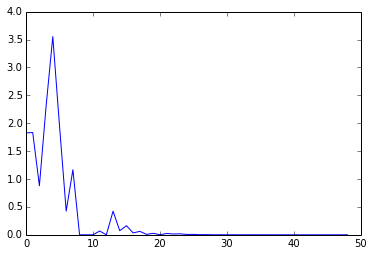

In [112]:
iterations = summary['iterations']
plot([it['gradient_max_norm'] for it in iterations])

## Point direction

In [113]:
p_initial = vsr.Vec(0,0,0).null().spin(M_initial)
p_initial = vsr.Vec(*p_initial.to_array()[:3])
l_initial = (vsr.Vec(1,0,0) ^ vsr.ni).spin(M_initial)
l_initial = vsr.Vec(*l_initial.to_array()[:3])
p_initial2 = vsr.Vec(*p_initial.to_array().copy()[:3])
l_initial2 = vsr.Vec(*l_initial.to_array().copy()[:3])
print(p0)
print(p_initial)
print(l0)
print(l_initial)
lds_calibrator = LaserDistanceSensorCalibrator(p_initial, l_initial, options)

0.1  0.2  0.3  
0.11  0.21  0.31  
0.5  0.866025  0  
0.804738  0.310617  0.505879  


In [114]:
for measurement in measurements:
    lds_calibrator.add_point_direction_residual_block(*measurement)

In [115]:
lds_calibrator.set_direction_parameterization('NORMALIZE')
p, l, summary2 = lds_calibrator.solve_point_direction()
print(summary2['brief_report'])
print(p)
print(l.unit())

Ceres Solver Report: Iterations: 62, Initial cost: 2.566668e-01, Final cost: 7.226376e-04, Termination: CONVERGENCE
0.0928943  0.210076  0.272721  
0.573503  0.740049  0.351313  


In [116]:
# print(summary2['full_report'])

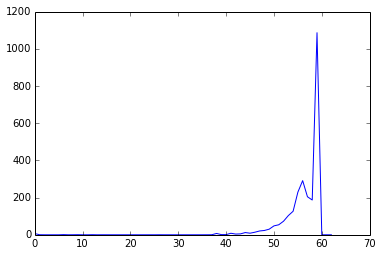

In [117]:
iterations = summary2['iterations']
plot([it['gradient_max_norm'] for it in iterations])

In [118]:
print p

0.0928943  0.210076  0.272721  


In [119]:
p = p0.null().spin(measurements[0][0])
p = vsr.Vec(p[0], p[1], p[2])
l = (l0 ^ vsr.ni).spin(measurements[0][0])
l = vsr.Vec(l[0], l[1], l[2])
n = vsr.Vec(dlp[0], dlp[1], dlp[2])
num = (vsr.Vec(dlp[0]*dlp[3], dlp[1]*dlp[3], dlp[2]*dlp[3]) - p <= n)
den = (l <= n)
dist = num / den
print(dist)

-0.0315675  


In [120]:
p2 = p_initial2.null().spin(measurements[0][0])
p2 = vsr.Vec(p2[0], p2[1], p2[2])
l2 = (l_initial2 ^ vsr.ni).spin(measurements[0][0])
l2 = vsr.Vec(l2[0], l2[1], l2[2])
n = vsr.Vec(dlp[0], dlp[1], dlp[2])
num2 = (vsr.Vec(dlp[0]*dlp[3], dlp[1]*dlp[3], dlp[2]*dlp[3]) - p2 <= n)
den2 = (l <= n)
dist2 = num2 / den2
print(dist2)

-0.0485409  


In [121]:
measurements[0][2]

0.09370221188659286

In [122]:
print (dist2 - dist) * 100

-1.69733  


In [123]:
p_initial2.to_array()


array([ 0.11,  0.21,  0.31])

In [124]:
# s = (dlp <= t2) / (vsr.ni <= (dlp <= t2))[0]
# np.allclose(r, np.sqrt((s <= s)[0]))

In [125]:
print(p)

1.81118  1.01534  0.0233285  


In [126]:
0.001 * np.random.randn()

-0.0008068436427008938

In [127]:
# for m in measurements:
#     print m[2]

## Point + angles

In [128]:
lds_calibrator = LaserDistanceSensorCalibrator(p_initial, np.pi/3, 0.0, options)

In [129]:
for measurement in measurements:
    lds_calibrator.add_point_angles_residual_block(*measurement)

In [130]:
p, theta, phi, summary3 = lds_calibrator.solve_point_angles()

In [131]:
print(summary3['brief_report'])

Ceres Solver Report: Iterations: 41, Initial cost: 4.496098e+02, Final cost: 8.875779e-03, Termination: CONVERGENCE


In [132]:
print(p)

0.107212  0.34573  0.303023  


In [133]:
print(theta)

1.1917789939


In [134]:
print(phi)

0.0


In [135]:
np.pi/3

1.0471975511965976